In [72]:
import os
import sys
import imp
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
dir_path = 'csvs/2020-02/'

In [74]:
# Get csv paths
paths = os.listdir(dir_path)

# Get dfs for each day
dfs_feb = [pd.read_csv(dir_path+f, engine='python') for f in paths]

# Get mean bw per day
means = [df.mean(axis=1) for df in dfs_feb]


In [75]:
# Construct dataframe with relays and their daily means
df_temp = pd.DataFrame()
df_temp['fingerprint'] = dfs_feb[0]['fingerprint']
for i,m in enumerate(means):
    df_temp['day '+str(i+1)] = m
    
# Find monthly bandwidth mean of each relay
df = pd.DataFrame()
df['fingerprint'] = df_temp['fingerprint']
df['mean_bw'] = df_temp.mean(axis=1)
df = df.sort_values(by='mean_bw', ascending=False)
df

,fingerprint,mean_bw
4622,niftyporcupine 7E281CD2C315C4F7A84BC7C8721C3BC...,51115.981096
693,F3Netze 7327876AE79C997DFE311A7B15B4FA875736BBD1,50484.524732
4625,niftyrabbitrat 25526E61B8BC22B662E3D4A50504021...,49166.550882
694,F3Netze 8E38B11E849336D62AB6264FBAE9B03C70F07863,49006.530403
4624,niftyquokka 906DCB390F2BA987AE258D745E60BAAABA...,48928.786704
...,...,...
98,ADEL ABF554C44C97825F46B1C9DEE14A2E2B62025D7E,986.798992
190,AnonKorea00 50402D3DAD83E8923CD7715917284C8489...,980.391698
1,0000001dxx B9609624E26C705289E57F95E30FD88D159...,674.035050
2286,Unnamed 3864A437EDAEBF7859B9CC71348E1214BEE5BF62,419.399023


[-50, 6000, 0, 52000]

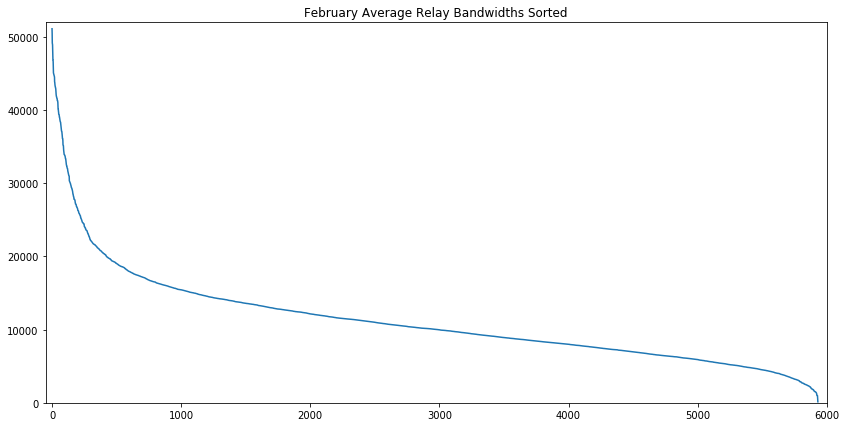

In [76]:
# See all sorted bandwidths
plt.figure(figsize=(14,7))
plt.plot(range(df.shape[0]), df['mean_bw'])
plt.title('February Average Relay Bandwidths Sorted')
plt.axis([-50, 6000, 0, 52000])


In [77]:
# See cumulative weight distribution and drop any relays outside 95% of variance
cum_weights = [(df['mean_bw'][:i].sum())/df['mean_bw'].sum() for i in range(1,df.shape[0]+1)]
relay_cutoff = 0
for i in range(df.shape[0]):
    if cum_weights[i]/cum_weights[-1] > 0.95:
        relay_cutoff = i
        break

Text(0.5, 1.0, 'Cumulative bandwidth weights')

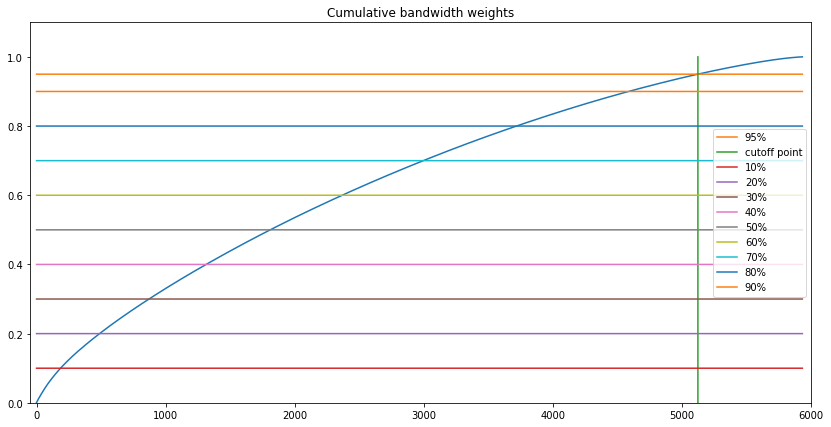

In [79]:
x = df.shape[0]
plt.figure(figsize=(14,7))
plt.plot(range(x), cum_weights)
plt.plot(range(x), [0.95] * x, label='95%')    # 95%
plt.plot([relay_cutoff]*x, cum_weights, label='cutoff point')

plt.plot(range(x), [0.10] * x, label='10%')    # 95%
plt.plot(range(x), [0.20] * x, label='20%')    # 95%
plt.plot(range(x), [0.30] * x, label='30%')    # 95%
plt.plot(range(x), [0.40] * x, label='40%')    # 95%
plt.plot(range(x), [0.50] * x, label='50%')    # 95%
plt.plot(range(x), [0.60] * x, label='60%')    # 95%
plt.plot(range(x), [0.70] * x, label='70%')    # 95%
plt.plot(range(x), [0.80] * x, label='80%')    # 95%
plt.plot(range(x), [0.90] * x, label='90%')    # 95%

plt.axis([-50, 6000, 0, 1.1])
plt.legend()

plt.title('Cumulative bandwidth weights')